## 라이브러리 불러오기

In [1]:
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

print(tf.__version__)

2023-10-09 14:29:09.680763: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-09 14:29:09.682351: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-09 14:29:09.705105: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-09 14:29:09.705128: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-09 14:29:09.705786: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

2.15.0-dev20231005


## 데이터세트 불러오기

In [2]:
import pathlib
workspace_dir = '작업 디렉토리'
data_dir = '데이터 디렉토리'
data_dir = pathlib.Path(data_dir)

DIR = 'classification'

batch_size = 32
img_height = 80
img_width = 80

image_count = len(list(data_dir.glob('*/*.jpg'))) + len(list(data_dir.glob('*/*.JPG'))) 
print(image_count)

2649


### 무잎벌 이미지 확인

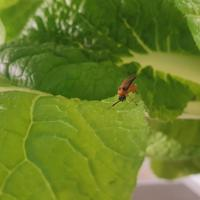

In [3]:
bee = list(data_dir.glob('bee/*.jpg')) + list(data_dir.glob('bee/*.JPG'))
PIL.Image.open(str(bee[0]))

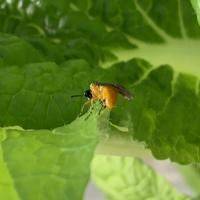

In [4]:
PIL.Image.open(str(bee[1]))

### 나방 이미지 확인

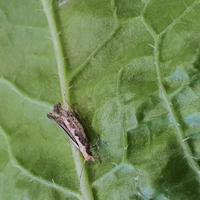

In [5]:
moth = list(data_dir.glob('moth/*.jpg')) + list(data_dir.glob('moth/*.JPG'))
PIL.Image.open(str(moth[0]))

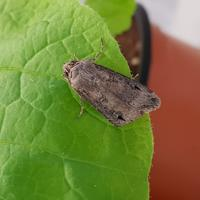

In [6]:
PIL.Image.open(str(moth[1]))

## 모델 생성

### 데이터세트 만들기

In [7]:
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="both",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 3640 files belonging to 4 classes.
Using 2912 files for training.
Using 728 files for validation.
['bee', 'butterfly', 'moth', 'stink']


2023-10-09 14:29:11.100888: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:916] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-09 14:29:11.113843: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2249] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


### 데이터 시각화하기

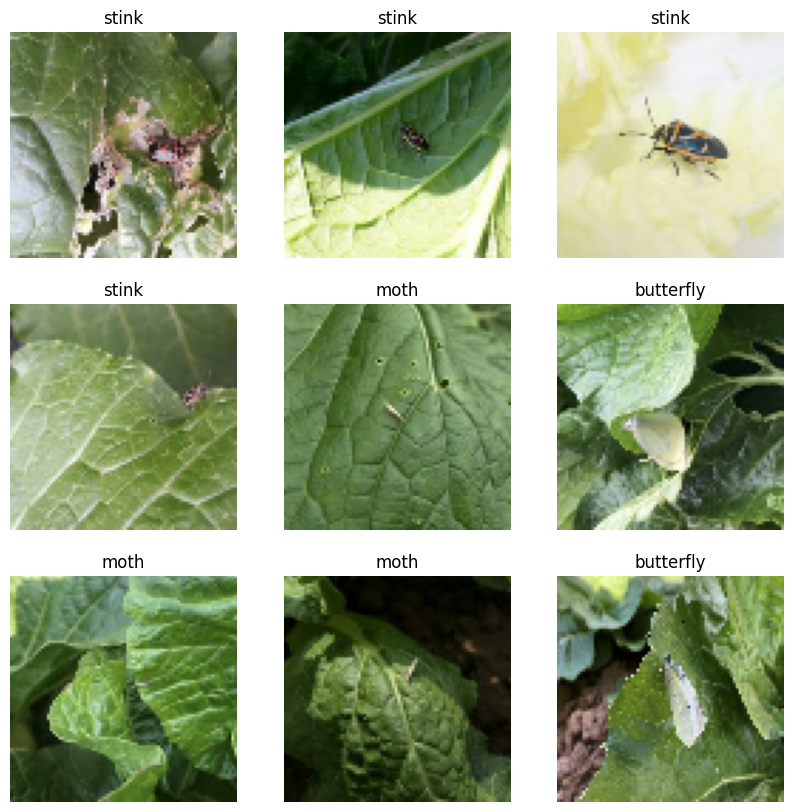

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 80, 80, 3)
(32,)


### 성능을 높이도록 데이터세트 구성하기

버퍼링된 프리페치를 사용하여 I/O를 차단하지 않고 디스크에서 데이터를 생성할 수 있도록 하겠습니다. 데이터를 로드할 때 다음 두 가지 중요한 메서드를 사용해야 합니다.

- `Dataset.cache()`는 첫 epoch 동안 디스크에서 이미지를 로드한 후 이미지를 메모리에 유지합니다. 이렇게 하면 모델을 훈련하는 동안 데이터세트가 병목 상태가 되지 않습니다. 데이터세트가 너무 커서 메모리에 맞지 않는 경우, 이 메서드를 사용하여 성능이 높은 온디스크 캐시를 생성할 수도 있습니다.
- `Dataset.prefetch`는 훈련하는 동안 데이터 전처리 및 모델 실행을 중첩시킵니다.

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### 데이터 증강

In [11]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

동일한 이미지에 데이터 증강을 여러 번 적용하여 몇 가지 증강 예제를 시각화합니다.

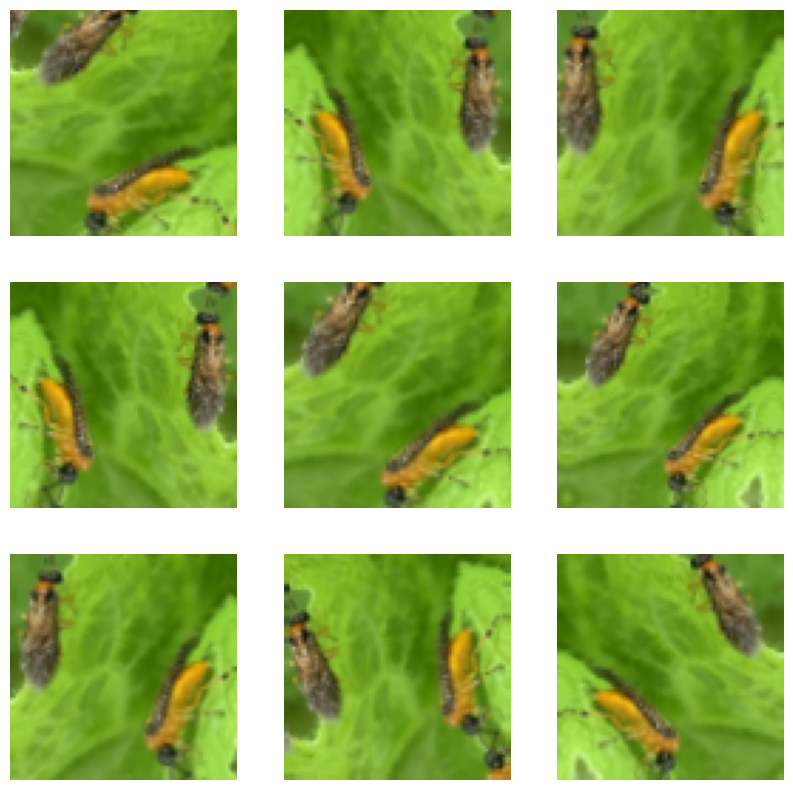

In [12]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### 모델 생성 및 요약

In [13]:
model = tf.keras.applications.MobileNetV3Small(
    input_shape=(80, 80, 3),
    alpha=1.0,
    minimalistic=True,
    include_top=False,
    weights=None,
    input_tensor=None,
    classes=4,
    pooling=None,
    dropout_rate=0.2,
    classifier_activation="softmax",
    include_preprocessing=False
)

x = model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# x = Dense(256, activation='relu')(x)  # 적절한 노드 수와 활성화 함수 설정
x = tf.keras.layers.Dense(4, activation='softmax')(x)  # 클래스 수에 맞는 분류 레이어 추가
model = tf.keras.Model(inputs=model.input, outputs=x)

model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 80, 80, 3)]          0         []                            
                                                                                                  
 Conv (Conv2D)               (None, 40, 40, 16)           432       ['input_1[0][0]']             
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 40, 40, 16)           64        ['Conv[0][0]']                
 lization)                                                                                        
                                                                                                  
 re_lu (ReLU)                (None, 40, 40, 16)           0         ['Conv/BatchNorm[0][0]']  

### 모델 컴파일

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### 모델 학습

In [16]:
epochs = 1
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

 1/91 [..............................] - ETA: 2s - loss: 0.9865 - accuracy: 0.6562

91/91 [==============================] - 4s 40ms/step - loss: 0.8789 - accuracy: 0.6164 - val_loss: 1.4132 - val_accuracy: 0.2376


### 모델 저장

In [ ]:
export_dir = f'{workspace_dir}/saved_model/{DIR}'
tf.saved_model.save(model, export_dir)

INFO:tensorflow:Assets written to: /home/shin/Graduation_Project/tensorflow_custom/tflite_model/saved_model/classification/assets


INFO:tensorflow:Assets written to: /home/shin/Graduation_Project/tensorflow_custom/tflite_model/saved_model/classification/assets


## TensorFlow Lite

### TensorFlow Lite 변환

In [19]:
# Convert the model.
tflite_model_path = f'{workspace_dir}/saved_model/{DIR}/saved_model.tflite'
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open(tflite_model_path, 'wb') as f:
  f.write(tflite_model)

2023-10-09 14:29:52.373937: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:916] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-09 14:29:52.374021: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-10-09 14:29:52.374076: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2023-10-09 14:29:52.374317: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:916] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-09 14:29:52.374378: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2

### TensorFlow Lite 모델 PC에서 실행하여 확인하기

In [20]:
TF_MODEL_FILE_PATH = tflite_model_path # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

## 양자화

### representative_data_gen() 메서드 선언

In [ ]:
numpy_arrays = []

for batch in train_ds:
    images, labels = batch
    for image in images:
      image_numpy = image.numpy()  # 이미지 배치를 NumPy 배열로 변환

      numpy_arrays.append(image_numpy)

print(len(numpy_arrays))

def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(numpy_arrays).batch(1).take(100):
    yield [input_value]


2912


### 양자화 수행

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # or tf.uint8
converter.inference_output_type = tf.int8  # or tf.uint8
tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmphu0u10yh/assets


INFO:tensorflow:Assets written to: /tmp/tmphu0u10yh/assets
/home/shin/.conda/envs/tf11/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2023-10-09 13:46:06.729998: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-10-09 13:46:06.730023: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-10-09 13:46:06.730160: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmphu0u10yh
2023-10-09 13:46:06.738217: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-10-09 13:46:06.738237: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmphu0u10yh
2023-10-09 13:46:06.763005: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-10-09 13:

### 양자화 모델 저장

In [ ]:
tflite_model_quant_path = f'{workspace_dir}/saved_model/{DIR}/saved_model_quant.tflite'
with open(tflite_model_quant_path, 'wb') as f:
    f.write(tflite_model_quant)

print(f"TensorFlow Lite 모델이 '{tflite_model_quant_path}'에 저장되었습니다.")

TensorFlow Lite 모델이 '/home/shin/Graduation_Project/tensorflow_custom/tflite_model/saved_model/classification/saved_model_quant.tflite'에 저장되었습니다.
